In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
from io import BytesIO
from PIL import Image
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay, CosineDecayRestarts
from tensorflow.keras.regularizers import l1
from keras.models import load_model
from keras.layers import Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import random
import time
import zipfile

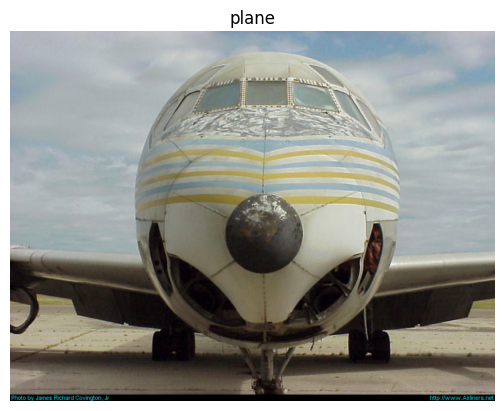

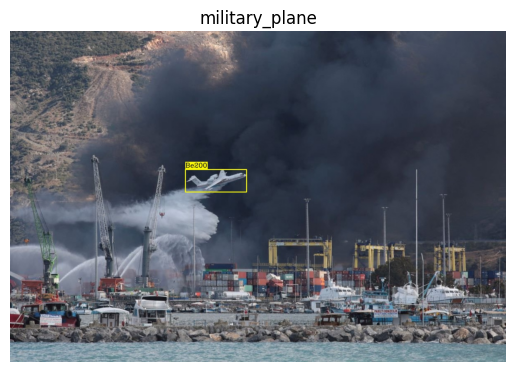

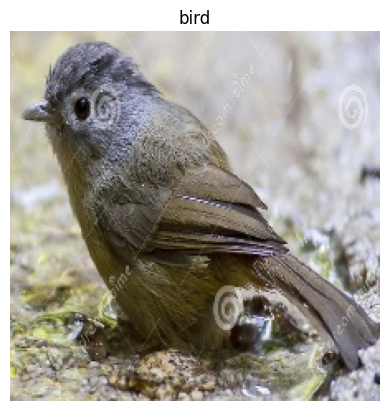

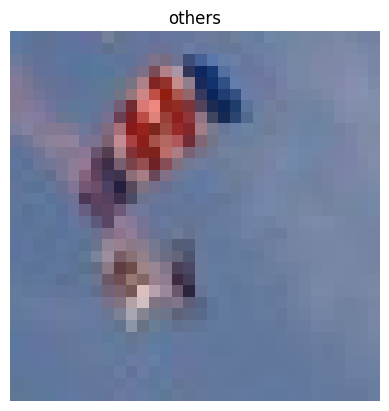

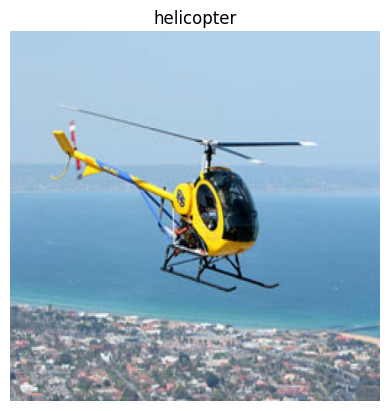

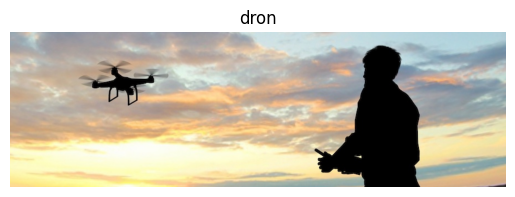

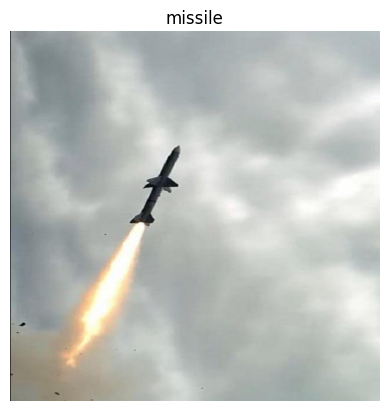

In [2]:
# Ruta al archivo ZIP
DIRECTORIO = "C:/Users/34633/OneDrive/Escritorio/FLY.zip"

# Categorías de las imágenes
CAT = ['plane', 'military_plane', 'bird', 'others', 'helicopter', 'dron', 'missile']

with zipfile.ZipFile(DIRECTORIO, 'r') as zip_ref:
    for categoria in CAT:
        # Buscar archivos de la categoría en la carpeta raíz "FLY/"
        categoria_archivos = [
            file_name for file_name in zip_ref.namelist() 
            if file_name.startswith(f"FLY/{categoria}/") and file_name.endswith(('.jpg', '.png', '.jpeg'))
        ]
        
        if categoria_archivos:  # Si hay imágenes en esta categoría
            # Mostrar la primera imagen
            primera_imagen = categoria_archivos[0]
            
            with zip_ref.open(primera_imagen) as img_file:
                # Convertir a formato compatible con OpenCV
                img_array = np.frombuffer(img_file.read(), np.uint8)
                img_rgb = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
                
                # Mostrar la imagen
                plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
                plt.title(categoria)
                plt.axis('off')
                plt.show()

# SE MUESTRA LA PRIMER IMAGEN DE CADA UNA DE LAS CLASES

In [3]:
# Se comprueba que efectivamente se trata de imagenes RBG

print(img_rgb)

[[[  5   2   0]
  [159 156 151]
  [167 164 159]
  ...
  [194 190 185]
  [194 190 185]
  [194 190 185]]

 [[  5   2   0]
  [159 156 151]
  [167 164 159]
  ...
  [194 190 185]
  [194 190 185]
  [194 190 185]]

 [[  5   2   0]
  [160 157 152]
  [167 164 159]
  ...
  [194 190 185]
  [194 190 185]
  [194 190 185]]

 ...

 [[  0   2   1]
  [119 133 132]
  [118 132 131]
  ...
  [200 205 196]
  [200 205 196]
  [201 206 197]]

 [[  0   2   1]
  [118 132 131]
  [117 131 130]
  ...
  [200 205 196]
  [201 206 197]
  [201 206 197]]

 [[  0   2   1]
  [117 131 130]
  [116 130 129]
  ...
  [201 206 197]
  [201 206 197]
  [201 206 197]]]


In [4]:
# Se comprueba resolución de imagen y que la misma sea a color. Al ser RGB siempre debe devolver 3

print(img_rgb.shape)

(640, 640, 3)


In [5]:
# Resolución deseada antes de pasar las imagenes por el modelo, principalemnte para optimizar los recursos computacionales
RESOLUTION = 150

# Crear un directorio temporal para descomprimir el ZIP
temp_dir = "temp_fly_data"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Extraer las imágenes desde el ZIP
with zipfile.ZipFile(DIRECTORIO, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Lista para los datos de entrenamiento
training_data = []

def create_training_data():
    for categoria in CAT:  # Recorrer cada categoría
        # Ruta a la carpeta dentro del directorio temporal
        path = os.path.join(temp_dir, 'FLY', categoria)
        clase_num = CAT.index(categoria)  # Índice de la categoría

        if not os.path.exists(path):
            print(f"No se encontró la carpeta para la categoría: {categoria}")
            continue

        # Procesar las imágenes dentro de esta categoría
        for img in tqdm(os.listdir(path), desc=f"Procesando {categoria}", unit="imágenes"):
            try:
                # Leer la imagen y redimensionarla
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Leer en escala de grises
                new_array = cv2.resize(img_array, (RESOLUTION, RESOLUTION))  # Redimensionar
                training_data.append([new_array, clase_num])  # Añadir a los datos
            except Exception as e:
                print(f"Imagen probablemente dañada: {img}. Error: {e}")

# Crear los datos de entrenamiento
create_training_data()

# Imprimir el tamaño total de los datos
print(f"Total de imágenes procesadas: {len(training_data)}")

Procesando dron:  55%|█████████████████████████████▉                         | 2808/5149 [00:35<00:24, 96.53imágenes/s]

Imagen probablemente dañada: video17_295.JPEG. Error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



Procesando dron:  89%|█████████████████████████████████████████████████▏     | 4599/5149 [00:52<00:05, 98.03imágenes/s]

Imagen probablemente dañada: video19_1900.JPEG. Error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



Procesando missile: 100%|███████████████████████████████████████████████████| 7459/7459 [00:36<00:00, 201.99imágenes/s]

Total de imágenes procesadas: 41612


In [9]:
# Mezclo aleatoriamente el orden de los elementos en training_data. Mezclar el conjunto ayuda a que el modelo vea una variedad de ejemplos de 
# diferentes clases en cada iteración. Esto es útil porque los datos originalmente se cargan en un orden específico por categoría, 
# lo cual podría afectar el entrenamiento del modelo si no se mezclan.

for muestra in training_data[:20]:

random.shuffle(training_data)          
    print(muestra[1])

0
0
3
1
5
1
0
6
1
0
4
6
6
1
3
4
6
4
4
0


In [10]:
x = []
y = []

for features, labels in training_data:
    x.append(features)
    y.append(labels)
print(x[0].reshape(-1, RESOLUTION, RESOLUTION, 3))

#Se chequea la forma de los datos
x = np.array(x).reshape(-1, RESOLUTION, RESOLUTION, 3)

[[[[121 121 121]
   [127 124 125]
   [123 123 123]
   ...
   [128 129 127]
   [125 120 118]
   [128 123 124]]

  [[123 123 123]
   [120 125 124]
   [122 124 124]
   ...
   [121 123 123]
   [127 127 126]
   [131 131 130]]

  [[121 123 124]
   [122 122 122]
   [124 123 123]
   ...
   [128 129 127]
   [127 127 127]
   [127 127 127]]

  ...

  [[ 10  10  10]
   [ 10  11  10]
   [ 10  11  10]
   ...
   [ 14  13  12]
   [ 10  10  11]
   [ 10  10  10]]

  [[ 12  11  10]
   [ 23  21  19]
   [117 110 101]
   ...
   [  1   1   1]
   [127 115  90]
   [  1   0   1]]

  [[ 58  52  49]
   [ 32  29  26]
   [ 57  50  43]
   ...
   [ 82  79  74]
   [ 88  80  68]
   [  1   1   1]]]]


In [11]:
# Guardar y cargar datos preprocesados de manera eficiente, lo cual es útil para ahorrar tiempo de procesamiento y facilitar la reutilización de datos.

y_inicial = y
x_inicial = x

pickle_out = open("x.pickle", "wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("x.pickle", "rb")
x = pickle.load(pickle_in)

In [12]:
# Dividir el conjunto de datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
y_train = np.array(y_train).astype('float32')  # Primero me aseguro de pasar los datos a tipo float
y_test = np.array(y_test).astype('float32')
x_train = x_train.astype(np.float32) / 255.0  # Normaliza el conjunto de entrenamiento
x_test = x_test.astype(np.float32) / 255.0  # Normaliza el conjunto de prueba

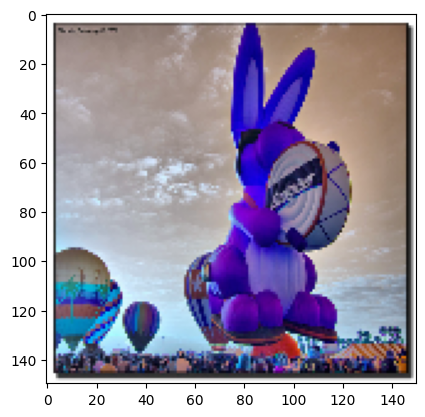

[[[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  ...
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]]

 [[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  ...
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]]

 [[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  ...
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]]

 ...

 [[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   0.99 0.99]
  ...
  [0.22 0.22 0.22]
  [0.64 0.64 0.64]
  [0.99 0.99 0.99]]

 [[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  ...
  [0.86 0.86 0.86]
  [0.95 0.95 0.95]
  [1.   1.   1.  ]]

 [[1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  ...
  [1.   1.   1.  ]
  [1.   1.   1.  ]
  [1.   1.   1.  ]]]


In [54]:
plt.imshow(x_train[0])
plt.show()
print(x_train[0])

In [15]:
# Se comprueba que el tipo de datos es una matriz tal como se espera

print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
# Reviso si hay etiquetas fuera del rango esperado

print("Etiquetas únicas en y_train:", np.unique(y_train))
print("Etiquetas únicas en y_test:", np.unique(y_test))

Etiquetas únicas en y_train: [0. 1. 2. 3. 4. 5. 6.]
Etiquetas únicas en y_test: [0. 1. 2. 3. 4. 5. 6.]


In [17]:
# Me aseguro que todas las etiquetas estén en el rango [0, 6] --> 7 clases

y_train = np.clip(y_train, 0, 6)
y_test = np.clip(y_test, 0, 6)

In [18]:
# Se verifcian las dimensiones de x_tain, y_train

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)

x_train:  (33289, 150, 150, 3)
y_train:  (33289,)


In [19]:
# Se dividen los datos en lotes

def data_generator(x_data, y_data, batch_size):
    while True:
        for i in range(0, len(x_data), batch_size):
            yield x_data[i:i+batch_size],  y_data[i:i+batch_size]

In [20]:
# Hiperparámetros

BATCH_SIZE = [32]

initial_lr = 1e-3
lr_schedule_cosine = CosineDecayRestarts(initial_lr, 1000, 2)


num_periods = 15
NUM_EPOCHS = 40
model = tf.keras.models.Sequential()

El modelo fue desarrollado con:
 - - - - - - 
- 4 capas convolucionales con tamaño de filtro 3x3, función de activación ReLU, padding y 
tamaño de 32, 64, 128 y 128 respectivamente. 
- 4 capas pooling, tras cada una de las capas convolucionales de 2x2, 3x3, 4x4 y 4x4 
respectivamente. 
- 2 capas fully connected con funciones de activación ReLU y Softmax respectivamente. 
- Ajuste de Learning Rate mediante el LR Scheduler y el uso del Cosine Decay Restarts, que 
  realiza una disminución del Learning rate mediante la función coseno y realiza reinicios a lo 
  del entrenamiento. 
- Uso del optimizador RMSProp con métrica accuracy. 
- Tamaño de lote de 32. 
- Uso de la parada temprana con tiempo de espera (patience) 10 épocas y monitorización de 
  la precisión en validación. 

In [57]:
# Definición del modelo

model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))

# Capa fully connected con función de activación 'relu' y última capa con función de activación 'softmax'
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

# Compilación del modelo
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr_schedule_cosine),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamiento
batch_size = BATCH_SIZE[0]
train_generator = data_generator(x_train, y_train, batch_size)
start_time = time.time()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=NUM_EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

end_time = time.time()
print(f"Tiempo de entrenamiento: {end_time - start_time} segundos")

# Predicción y cálculo de métricas
y_pred = np.argmax(model.predict(x_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)

for i in range(conf_matrix.shape[0]):
    tp = conf_matrix[i, i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Clase: {i} - TP: {tp} - FP: {fp} - FN: {fn} - Precisión: {precision:.2f} - Recall: {recall:.2f} - F1 Score: {f1_score:.2f}")

Epoch 1/40


C:\Users\34633\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1040/1040 ━━━━━━━━━━━━━━━━━━━━ 120s 115ms/step - accuracy: 0.4955 - loss: 1.2894 - val_accuracy: 0.6303 - val_loss: 0.9929
Epoch 2/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 117s 113ms/step - accuracy: 0.6936 - loss: 0.8525 - val_accuracy: 0.7851 - val_loss: 0.6017
Epoch 3/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 114s 110ms/step - accuracy: 0.8273 - loss: 0.4886 - val_accuracy: 0.7827 - val_loss: 0.6147
Epoch 4/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 111s 107ms/step - accuracy: 0.7974 - loss: 0.5744 - val_accuracy: 0.7895 - val_loss: 0.6130
Epoch 5/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 110s 106ms/step - accuracy: 0.8617 - loss: 0.3968 - val_accuracy: 0.8223 - val_loss: 0.5602
Epoch 6/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 111s 106ms/step - accuracy: 0.9196 - loss: 0.2345 - val_accuracy: 0.8546 - val_loss: 0.5303
Epoch 7/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 888s 854ms/step - accuracy: 0.9517 - loss: 0.1440 - val_accuracy: 0.8217 - val_loss: 0.6711
Epoch 8/40
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 117s 112ms/step - accuracy: 0.8

<u>RESULTADOS OBTENIDOS DEL ENTRENAMIENTO:<br></u>

El *accuracy* final del entrenamiento alcanzó 98.95%, lo que indica que el modelo clasifica correctamente la mayoría de los ejemplos en el conjunto de entrenamiento<br>
Sin embargo, el *val_accuracy* es más bajo, alcanzando un máximo de 85,95%. Esto sugiere que el modelo funciona bien en los datos de entrenamiento, pero tiene dificultades para generalizar a los datos de validación. Lo que puede ser un indicio de Sobreajuste (Overfitting), cuando se evidencia una diferencia (en este caso pequeña) entre el accuracy de entrenamiento y validación.<br>
Las *precisiones por clase* son variadas, oscilando entre 0.71 y 0.96. En general, son buenas métricas. La más baja es de 0.71, osea que el modelo comete más errores al clasificar la clase 1.<br>
Un *F1-score* de 0.81 a 0.94 en la mayoría de las clases es bastante bueno, pero hay margen de mejora, especialmente en clases con métricas más bajas como el de la clase 1 mencionado anteriormente.<br>
Como conslución más general se podría decir que el modelo tiene un buen desempeño en el conjunto de entrenamiento, pero se podría tener en cuenta, el optimizarlo para mejorar la validación.

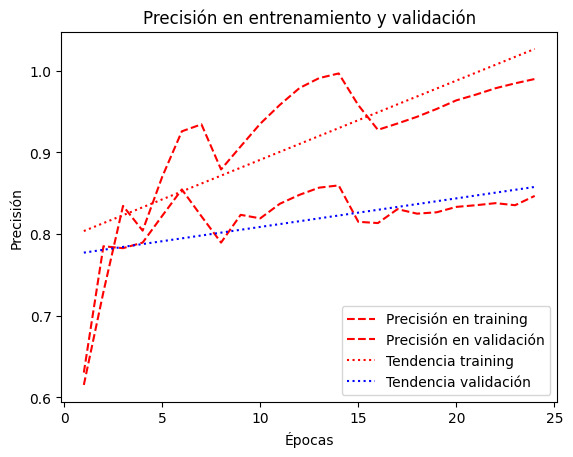

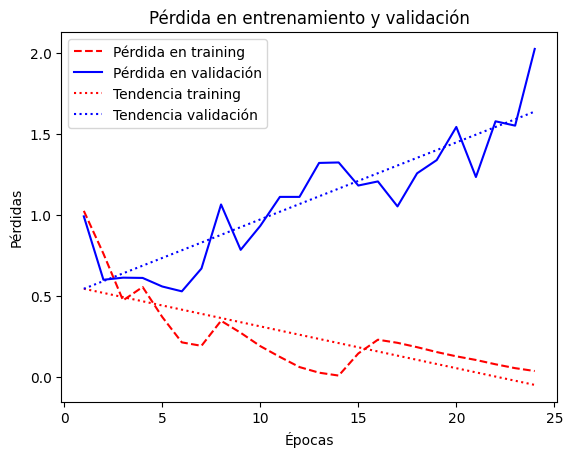

In [58]:
# Datos
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Gráfico de precisión
plt.figure()
plt.plot(epochs, acc, 'r--', label='Precisión en training')
plt.plot(epochs, val_acc, 'r--', label='Precisión en validación')

# Linea de tendencia para precisión 
z_acc = np.polyfit(epochs, acc, 1)   #Ajuste lineal
p_acc = np.poly1d(z_acc)
plt.plot(epochs, p_acc(epochs), 'r:', label='Tendencia training')

z_val_acc = np.polyfit(epochs, val_acc, 1)  #Ajuste lineal
p_val_acc = np.poly1d(z_val_acc)
plt.plot(epochs, p_val_acc(epochs), 'b:', label='Tendencia validación')

plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de pérdidas
plt.figure()
plt.plot(epochs, loss, 'r--', label='Pérdida en training')
plt.plot(epochs, val_loss, 'b', label='Pérdida en validación')

#Ajustar linea de tendencia para pérdida
z_loss = np.polyfit(epochs, loss, 1)    #Ajuste lineal
p_loss = np.poly1d(z_loss)
plt.plot(epochs, p_loss(epochs), 'r:', label='Tendencia training')

z_val_loss = np.polyfit(epochs, val_loss, 1)  #Ajuste lineal
p_val_loss = np.poly1d(z_val_loss)
plt.plot(epochs, p_val_loss(epochs), 'b:', label='Tendencia validación')

plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdidas')
plt.legend()

plt.show()

A continuación, se analiza el gráfico del comportamiento del modelo al utilizar la parada temprana. 
Se puede observar como el entrenamiento se reduce a 25 épocas y 
los resultados son igualmente buenos que los obtenidos al entrenamiento previo de 40 épocas. 
Estos resultados se consiguen gracias al uso de la parada temprana, ya que, al transcurrir 10 épocas
sin mejorar los valores de la precisión en validación, el modelo detiene el entrenamiento para 
escoger la configuración de pesos establecida en la época que obtuvo los mejores resultados 
durante el proceso de entrenamiento.<br>
Estableciendo el parámetro *patience* en 5 también se consigue un buen resultado consumiendo menos recursos, aunque levemente en desventaja con los resultados actuales.


<u>Gráfico de Precisión</u>

*Tendencia de Entrenamiento:*<br>
La precisión en entrenamiento aumenta de manera constante, alcanzando valores cercanos al 100%. Esto indica que el modelo aprende efectivamente los datos de entrenamiento.

*Tendencia de Validación:*<br>
La precisión de validación mejora al principio, pero se estabiliza alrededor del 85%-87% después de algunas épocas, sin alcanzar el nivel de la precisión en entrenamiento.

Entiendo que se puede interpretar un posible Sobreajuste, observando que el modelo generaliza peor en los datos de validación. 


<u>Gráfico de Pérdida</u>

*Tendencia de Entrenamiento*:<br>
La pérdida en entrenamiento disminuye rápidamente y se mantiene baja, lo que indica un buen ajuste a los datos de entrenamiento.<br>

*Tendencia de Validación:*
La pérdida de validación no sigue la misma tendencia; muestra una tendencia a aumentar ligeramente después de las primeras épocas. Esto refuerza la hipótesis de sobreajuste. --> *En problemas reales, un leve sobreajuste no necesariamente implica una limitación crítica, especialmente si el rendimiento en datos nuevos (como los del conjunto de validación) se mantiene robusto. Por lo tanto, el modelo se considera satisfactorio para esta aplicación. Decido no optimizar más este aspecto debido a que el modelo logra clasificar correctamente las imágenes en el conjunto de validación y genera métricas satisfactorias en términos de precisión, recall y F1-score.*



261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step


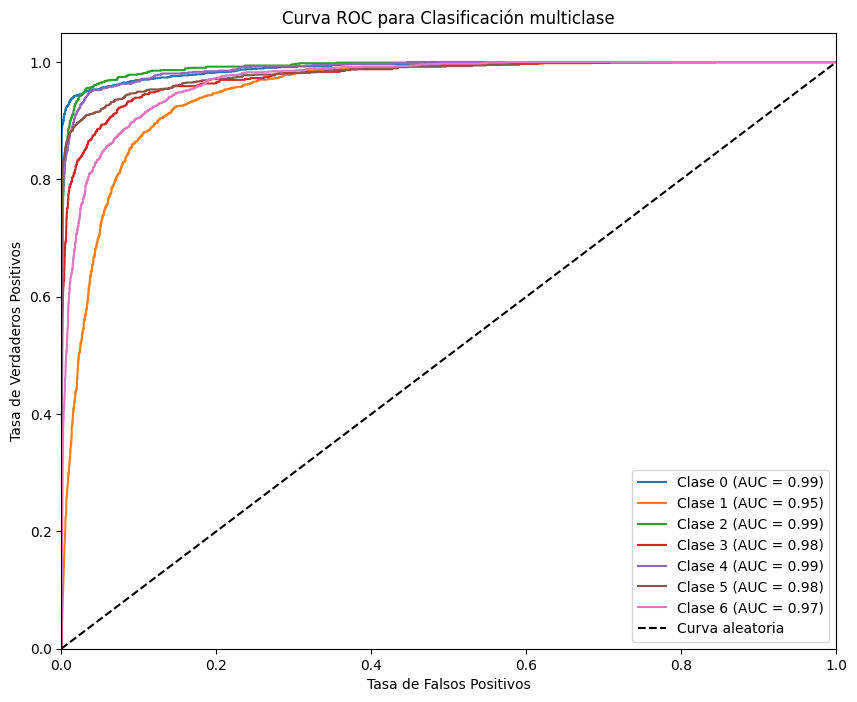

In [59]:
#se define el número de clases
n_clases = 7

#Binarizar y_test
y_test_bin = label_binarize(y_test, classes=np.arange(n_clases))

#Predecir probabilidades para cada clase
y_pred_prob = model.predict(x_test)

#Gráfico ROC
plt.figure(figsize=(10, 8))

#Se calcula y se traza la curva ROC para cada clase
for i in range(n_clases):
    # calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    # Se calcula el area bajo la curva ROC
    roc_auc = auc(fpr, tpr)

    # Se traza la curva ROC
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')

# Configuración del gráfico
plt.plot([0, 1], [0, 1], 'k--', label='Curva aleatoria')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC para Clasificación multiclase')
plt.legend(loc="lower right")
plt.show()

**Los resultados obtenidos en esta métrica están en todos los casos por encima del 95% y con un promedio de 0.98%, lo que 
permite tener una tasa de predicciones correcta muy elevada.**

261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


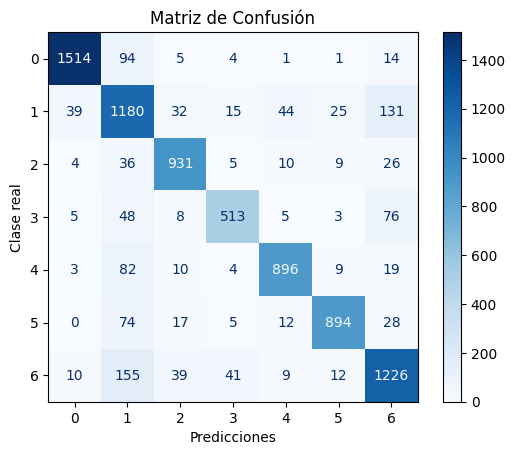

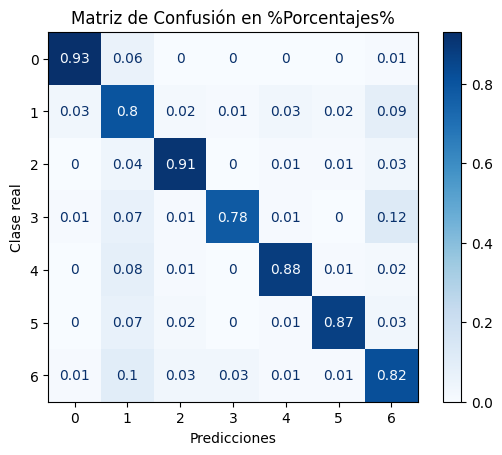

In [60]:
# Predecir las clases para el conjunto de prueba
y_pred = np.argmax(model.predict(x_test), axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

#Crear la visualización de la matriz de confusión con números
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cmap = 'Blues'  # Mapa de colores personalizado
cm_display.plot(cmap=cmap)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Clase real')
plt.show()

#Calcular la matriz de confusión con porcentajes
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

#Configurar el formato para mostrar solo 1 decimal
np.set_printoptions(precision=2)

#Redondear los datos de la matriz de confusión con porcentajes a 1 decimal
conf_matrix_rounded = np.round(conf_matrix, 2)

#Crear la visualización de la matriz de confusión con porcentajes
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rounded)
cmap = 'Blues'  # Mapa de colores personalizado
cm_display.plot(cmap=cmap)
plt.title('Matriz de Confusión en %Porcentajes%')
plt.xlabel('Predicciones')
plt.ylabel('Clase real')
plt.show()

Analizando la matriz de confusión, se comprueba que la precisión más baja obtenida es del 78% 
para la clase 3, y la más alta es del 93% para la clase 0. En promedio para todas las clases la precisión es mayor que el 85%.<br>
La clase 3, que contiene imágenes de objetos voladores 'recreativos', probablemente haya obtenido el porcentaje más bajo debido a que posee menos muestras que las demás clases, aproximadamente unas 2000 imágenes menos. Por lo tanto, es posible que añadiendo más imagenes a la carpeta de *others* el modelo sea tan preciso como se espera. Considero que si todas las clases partieran de una misma cantidad de muestras o al menos una cantidad más equitativa de muestras, el resultado general del modelo aumentaria considerablemente.<br>

A modo de conslusión, el modelo conseguido es el más efectivo. Esto lo determino luego de haber realizado variantes, como:
- El uso de distintos hiperparámetros
- La implementación de un canal de imagen en escala de grises
- De haber realizado un entrenamiento con la red neuronal **Xception** con el fin de realizar una comparativa con la red neuronal 
  configurada en el presente trabajo. Los resultados obtenidos con la red neuronal Xception no han sido favorables.

In [61]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 25, 25, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 6, 128)           │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,407,375 (5.37 MB)

 Trainable params: 703,687 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 703,688 (2.68 MB)

In [62]:
model.save('aerial_objects.keras')

In [63]:
custom_objects = {'softmax_v2': Activation('softmax')}
new_model = load_model('aerial_objects.keras', custom_objects=custom_objects)

In [65]:
predictions = new_model.predict([x_test])

261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step


In [66]:
print(predictions)

[[1.47e-11 2.96e-08 1.08e-10 ... 8.84e-14 3.50e-13 1.00e+00]
 [1.57e-12 7.97e-01 5.94e-04 ... 9.38e-04 7.74e-02 1.24e-01]
 [1.70e-24 4.19e-12 2.08e-24 ... 1.00e+00 3.41e-20 1.69e-16]
 ...
 [5.22e-06 5.27e-01 7.89e-08 ... 5.58e-05 1.38e-03 3.60e-01]
 [8.84e-30 1.41e-14 2.67e-14 ... 7.92e-16 1.00e+00 1.81e-22]
 [4.26e-36 1.01e-17 5.58e-25 ... 6.50e-28 1.00e+00 2.77e-24]]


In [73]:
# Se realiza una prueba para comprobar que el modelo clasifica y asigna el riesgo correspondiente

prueba = 18
print(np.argmax(predictions[prueba]))
prediction_class = np.argmax(predictions[prueba])

if prediction_class == 0:
    print('Avión civíl identificado, POCO RIESGO')
elif prediction_class == 1:
    print('Avión militar identificado, ¡ALTO RIESGO!')
elif prediction_class == 2:
    print('Pájaro identificado, NO HAY RIESGO')
elif prediction_class == 3:
    print('Objeto recreativo (transbordador espacial, dirigibles, globos aeroestáticos, paracaisdista), POCO RIESGO')
elif prediction_class == 4:
    print('helicóptero identificado, RIESGO MEDIO!')
elif prediction_class == 5:
    print('Dron identificado, RIESGO MEDIO!')
elif prediction_class == 6:
    print('Misil identificado aproximandose a la tierra, ¡ALTO RIESGO!')
else:
    print('Objeto NO identificado')

6
Misil identificado aproximandose a la tierra, ¡ALTO RIESGO!


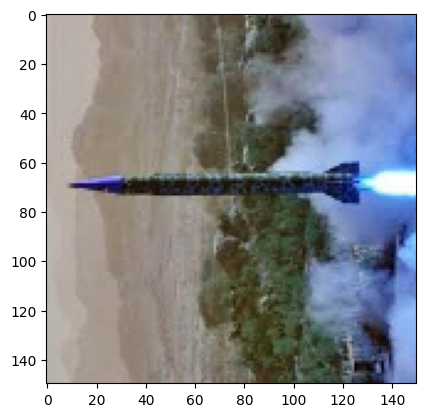

In [74]:
# Se comprueba que la predicción realizada es correcta

plt.imshow(x_test[prueba])
plt.show()